# Loading the Nerfstudio model

In [1]:
from nerfstudio.utils.eval_utils import eval_setup
from pathlib import Path

# Config file of trained nerfstudio model
load_config = Path(
    "outputs/figurines_processed/splatfacto/2024-12-06_145554/config.yml"
)
config, pipeline, _, step = eval_setup(
    load_config,
    eval_num_rays_per_chunk=None,
    test_mode="test",
)

cameras = pipeline.datamanager.train_dataset.cameras
image_dataset = pipeline.datamanager.train_dataset
model = pipeline.model
model.eval()  # Needed?

xyz = model.means

2024-12-06 17:58:48.337127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/nerfstudio/field_components/activations.py:32: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float32)
/graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/nerfstudio/field_components/activations.py:39: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, g):


[17:58:52] Auto image downscale factor of 1                                                 ]8;id=20204;file:///graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=38159;file:///graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/torchmetrics/functional/image/lpips.py:323: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Loading latest checkpoint from load_dir

/graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/nerfstudio/utils/eval_utils.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loade

✅ Done loading checkpoint from 
outputs/figurines_processed/splatfacto/2024-12-06_145554/nerfstudio_models/step-000029999.ckpt

# Helper functions for SAGS segmentation

In [2]:
import torch

import torch.nn.functional as F
import torchvision.transforms.functional as func

# from SAGS.seg_utils import conv2d_matrix, compute_ratios, update
from nerfstudio.cameras.cameras import Cameras


def get_viewmat(optimized_camera_to_world):
    """
    function that converts c2w to gsplat world2camera matrix, using compile for some speed
    """
    R = optimized_camera_to_world[:, :3, :3]  # 3 x 3
    T = optimized_camera_to_world[:, :3, 3:4]  # 3 x 1
    # flip the z and y axes to align with gsplat conventions
    R = R * torch.tensor([[[1, -1, -1]]], device=R.device, dtype=R.dtype)
    # analytic matrix inverse to get world2camera matrix
    R_inv = R.transpose(1, 2)
    T_inv = -torch.bmm(R_inv, T)
    viewmat = torch.zeros(R.shape[0], 4, 4, device=R.device, dtype=R.dtype)
    viewmat[:, 3, 3] = 1.0  # homogenous
    viewmat[:, :3, :3] = R_inv
    viewmat[:, :3, 3:4] = T_inv
    return viewmat


def get_3d_prompts(prompts_2d, point_image, xyz, depth=None):
    r = 4
    x_range = torch.arange(prompts_2d[0] - r, prompts_2d[0] + r)
    y_range = torch.arange(prompts_2d[1] - r, prompts_2d[1] + r)
    x_grid, y_grid = torch.meshgrid(x_range, y_range)
    neighbors = torch.stack([x_grid, y_grid], dim=2).reshape(-1, 2).to("cuda")
    prompts_index = [torch.where((point_image == p).all(dim=1))[0] for p in neighbors]
    indexs = []
    for index in prompts_index:
        if index.nelement() > 0:
            indexs.append(index)
    indexs = torch.unique(torch.cat(indexs, dim=0))
    indexs_depth = depth[indexs]
    valid_depth = indexs_depth[indexs_depth > 0]
    _, sorted_indices = torch.sort(valid_depth)
    valid_indexs = indexs[depth[indexs] > 0][sorted_indices[0]]

    return xyz[valid_indexs][:3].unsqueeze(0)


## Given 1st view point prompts, find corresponding 3D Gaussian point prompts
def generate_3d_prompts(xyz, viewpoint_camera: Cameras, prompts_2d):
    w2c_matrix = get_viewmat(viewpoint_camera.camera_to_worlds)[0].cuda()  # 4x4
    intrinsics = torch.eye(4, device="cuda")
    intrinsics[:3, :3] = viewpoint_camera.get_intrinsics_matrices().squeeze()
    # intrinsics = viewpoint_camera.get_intrinsics_matrices()
    full_matrix = (intrinsics @ w2c_matrix).transpose(0, 1)  # 4x4
    # project to image plane
    xyz = F.pad(input=xyz, pad=(0, 1), mode="constant", value=1)
    p_hom = (xyz @ full_matrix).transpose(0, 1)  # N, 4 -> 4, N
    p_w = 1.0 / (p_hom[-2, :] + 0.0000001)
    p_proj = p_hom[:2, :] * p_w

    p_view = (xyz @ w2c_matrix.transpose(0, 1)[:, :3]).transpose(0, 1)  # N, 3 -> 3, N
    depth = p_view[-1, :].detach().clone()
    # valid_depth = depth >= 0

    point_image = p_proj.detach().clone()
    point_image = torch.round(point_image.transpose(0, 1)).long()

    prompts_2d = torch.tensor(prompts_2d).to("cuda")
    prompts_3d = []
    for i in range(prompts_2d.shape[0]):
        prompts_3d.append(get_3d_prompts(prompts_2d[i], point_image, xyz, depth))
    prompts_3D = torch.cat(prompts_3d, dim=0)

    return prompts_3D


## Project 3D points to 2D plane
def project_to_2d(viewpoint_camera, points3D):
    w2c_matrix = get_viewmat(viewpoint_camera.camera_to_worlds)[0].cuda()  # 4x4
    intrinsics = torch.eye(4, device="cuda")
    intrinsics[:3, :3] = viewpoint_camera.get_intrinsics_matrices()
    # intrinsics = viewpoint_camera.get_intrinsics_matrices()
    full_matrix = (intrinsics @ w2c_matrix).transpose(0, 1)  # 4x4
    # project to image plane
    if points3D.shape[-1] != 4:
        points3D = F.pad(input=points3D, pad=(0, 1), mode="constant", value=1)
    p_hom = (points3D @ full_matrix).transpose(0, 1)  # N, 4 -> 4, N
    p_w = 1.0 / (p_hom[-2, :] + 0.0000001)
    p_proj = p_hom[:2, :] * p_w

    # p_view = (xyz @ w2c_matrix.transpose(0, 1)[:, :3]).transpose(0, 1)  # N, 3 -> 3, N
    # depth = p_view[-1, :].detach().clone()
    # valid_depth = depth >= 0

    point_image = p_proj.detach().clone()
    point_image = torch.round(point_image.transpose(0, 1))

    return point_image


## Single view assignment
def mask_inverse(xyz, viewpoint_camera, sam_mask):
    w2c_matrix = get_viewmat(viewpoint_camera.camera_to_worlds)[0].cuda()  # 4x4
    # project to camera space
    xyz = F.pad(input=xyz, pad=(0, 1), mode="constant", value=1)
    p_view = (xyz @ w2c_matrix.transpose(0, 1)[:, :3]).transpose(0, 1)  # N, 3 -> 3, N
    depth = p_view[-1, :].detach().clone()
    valid_depth = depth >= 0

    h = viewpoint_camera.image_height.squeeze().item()
    w = viewpoint_camera.image_width.squeeze().item()

    if sam_mask.shape[0] != h or sam_mask.shape[1] != w:
        sam_mask = (
            func.resize(sam_mask.unsqueeze(0), (h, w), antialias=True).squeeze(0).long()
        )
    else:
        sam_mask = sam_mask.long()

    point_image = project_to_2d(viewpoint_camera, xyz)
    point_image = point_image.long()

    # 判断x,y是否在图像范围之内
    valid_x = (point_image[:, 0] >= 0) & (point_image[:, 0] < w)
    valid_y = (point_image[:, 1] >= 0) & (point_image[:, 1] < h)
    valid_mask = valid_x & valid_y & valid_depth
    point_mask = torch.full((point_image.shape[0],), -1)

    point_mask[valid_mask.cpu()] = sam_mask[
        point_image[valid_mask.cpu(), 1].cpu(), point_image.cpu()[valid_mask.cpu(), 0]
    ]
    indices_mask = torch.where(point_mask == 1)[0]

    return point_mask, indices_mask


## Multi-view label voting
def ensemble(multiview_masks, threshold=0.7):
    # threshold = 0.7
    multiview_masks = torch.cat(multiview_masks, dim=1)
    vote_labels, _ = torch.mode(multiview_masks, dim=1)
    # # select points with score > threshold
    matches = torch.eq(multiview_masks, vote_labels.unsqueeze(1))
    ratios = torch.sum(matches, dim=1) / multiview_masks.shape[1]
    ratios_mask = ratios > threshold
    labels_mask = (vote_labels == 1) & ratios_mask
    indices_mask = torch.where(labels_mask)[0].detach().cpu()

    return vote_labels, indices_mask

## Prepare SAM2 predictor

In [3]:
import numpy as np

# from sam2 import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./libs/sam2/checkpoints/sam2.1_hiera_tiny.pt"  # maybe use large SAM2 instead of tiny
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))


# point guided
def self_prompt(point_prompts, sam_feature):
    input_point = point_prompts.detach().cpu().numpy()
    # input_point = input_point[::-1]
    input_label = np.ones(len(input_point))

    predictor._features = sam_feature
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    # return_mask = (masks[ :, :, 0]*255).astype(np.uint8)
    # return_mask = (masks[id, :, :, None] * 255).astype(np.uint8)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    # return highest scoring mask
    return_mask = (masks[0, :, :, None] * 255).astype(np.uint8)

    return return_mask / 255

/graphics/scratch2/students/siemssen/styleTransfer/libs/sam2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


# Preprocess SAM2 on every view image

This preprocessing makes the final GS segmentation more efficient.

In [4]:
import cv2
import numpy as np
from tqdm import tqdm

sam_features = {}
render_images = {}
print("Prepocessing: extracting SAM features...")
for i, camera in tqdm(enumerate(cameras)):
    # image_name = train
    render_pkg = model.get_outputs_for_camera(cameras[i : i + 1])

    render_image = render_pkg["rgb"].detach().cpu().numpy()
    render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

    with torch.inference_mode() and torch.autocast("cuda", dtype=torch.bfloat16):
        predictor.set_image(render_image)
    sam_features[i] = predictor._features

Prepocessing: extracting SAM features...


0it [00:00, ?it/s]/graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
270it [06:09,  1.37s/it]


## Select point prompts given the first view

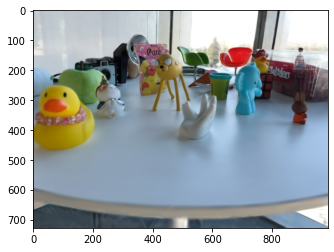

In [5]:
from matplotlib import pyplot as plt

# first view
idx = 0
view = cameras[idx : idx + 1]

# Render image from the gsplat model in the given view
render_pkg = model.get_outputs_for_camera(cameras[idx : idx + 1])

render_image = render_pkg["rgb"].detach().cpu().numpy()
render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

plt.imshow(render_image)

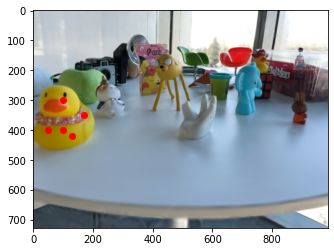

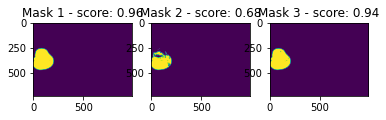

In [6]:
## can select input points from 1st view
input_point = (
    np.asarray([[100, 400], [100, 300], [130, 420], [170, 350], [50, 400]])
).astype(np.int32)
# input_point = (np.asarray([[1200, 700]])).astype(np.int32)
input_label = np.ones(len(input_point))

# visualize selected points
plt.imshow(render_image)
plt.scatter(input_point[:, 0], input_point[:, 1], c="r")
plt.show()

# Generate 2D segmentation masks for given rendered image
predictor.set_image(render_image)
with torch.inference_mode() and torch.autocast("cuda", dtype=torch.bfloat16):
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

plt.subplot(1, 3, 1)
plt.imshow(masks[0])
plt.title(f"Mask 1 - score: {scores[0]:.2f}")
plt.subplot(1, 3, 2)
plt.imshow(masks[1])
plt.title(f"Mask 2 - score: {scores[1]:.2f}")
plt.subplot(1, 3, 3)
plt.imshow(masks[2])
plt.title(f"Mask 3 - score: {scores[2]:.2f}")
plt.show()

## Start 3D-GS Segmentation

In [7]:
print("Start GS Segmentation...")

from plyfile import PlyData, PlyElement
import copy

# mask_id = 2

# generate 3D prompts
xyz = model.means
prompts_3d = generate_3d_prompts(xyz, cameras[idx : idx + 1], input_point)


multiview_masks = []
sam_masks = []

obj_cameras = []

for i, view in enumerate(cameras):
    prompts_2d = project_to_2d(cameras[i : i + 1], prompts_3d)

    valid_prompts = []
    for j, prompt in enumerate(prompts_2d):
        if prompt[0] >= 0 and prompt[1] >= 0:
            if (
                prompt[0] < view.image_width.item()
                and prompt[1] < view.image_height.item()
            ):
                valid_prompts.append(j)
    prompts_2d = prompts_2d[valid_prompts]

    if not valid_prompts:  # Object is not visible in this view
        continue

    obj_cameras.append(i)
    # sam prediction
    sam_mask = self_prompt(prompts_2d, sam_features[i])
    if len(sam_mask.shape) != 2:
        sam_mask = torch.from_numpy(sam_mask).squeeze(-1)  # .to("cuda")
    else:
        sam_mask = torch.from_numpy(sam_mask)  # .to("cuda")
    sam_mask = sam_mask.long()
    sam_masks.append(sam_mask)

    # if i % 25 == 0:
    #     render_pkg = model.get_outputs_for_camera(cameras[i : i + 1])

    #     render_image = render_pkg["rgb"].detach().cpu().numpy()
    #     render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

    #     # project 3d prompts to 2d prompts
    #     plt.imshow(render_image)
    #     plt.scatter(prompts_2d[:, 0].cpu(), prompts_2d[:, 1].cpu(), c="r")
    #     plt.show()
    #     plt.imshow(sam_mask)
    #     plt.show()

    # mask assignment to gaussians
    point_mask, indices_mask = mask_inverse(xyz, cameras[i : i + 1], sam_mask)

    multiview_masks.append(point_mask.unsqueeze(-1))
    # # gaussian decomposition as an intermediate process
    # if args.gd_interval != -1 \
    #                     and i % args.gd_interval == 0:  #
    #     gaussians = gaussian_decomp(gaussians, view, sam_mask, indices_mask)

# multi-view label ensemble
_, final_mask = ensemble(multiview_masks, 0.7)

print("Segmentation Done!")

print(f"Number of Gaussians in the object mask: {len(final_mask)}")

Start GS Segmentation...


/graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Segmentation Done!
Number of Gaussians in the object mask: 3070


# Testing Segmentation Results

final_mask is a binary mask on the Gaussians indicating which Gaussians belong to the clicked object.

Here, we render only the masked object gaussians from a random viewpoint. (Change viewmats variable to use a different viewpoint)

NOTE: Object might not be visible from all viewpoints.

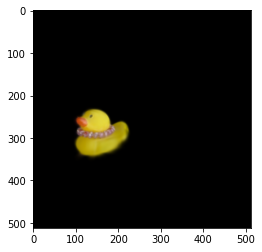

In [8]:
from pyexpat import features
from gsplat import rasterization

means = model.means[final_mask].cuda()
quats = model.quats[final_mask].cuda()
scales = model.scales[final_mask].cuda()
colors = model.colors[final_mask].cuda()
opacities = model.opacities[final_mask].cuda()

viewmats = get_viewmat(
    cameras[20:21].camera_to_worlds
).cuda()  # Change this variable to view the Gaussians from different views.
Ks = cameras[0:1].get_intrinsics_matrices().cuda()

colors, alpha, meta = rasterization(
    means,
    quats,
    torch.exp(scales),
    torch.sigmoid(opacities).squeeze(-1),
    colors.squeeze(1),
    viewmats,
    Ks,
    512,
    512,
    sh_degree=None,
    packed=False,
)

plt.imshow(colors.cpu().detach().numpy().squeeze(0))
plt.show()

## Load style image from Wikiart dataset

Change idx variable to use a different style image

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

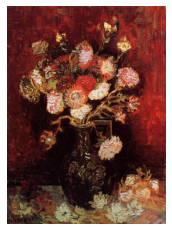

In [10]:
from datasets import load_dataset

ds = load_dataset("huggan/wikiart", split="train", streaming=True)

idx = 6
for i, data in enumerate(ds):
    if i == idx:
        break
image = data["image"]
plt.imshow(image)
plt.axis("off")
plt.show()

# Save PIL Image to style.png
image.save("style.png")

## Helper function for the StyleSplat style transfer

In [11]:
import torchvision


def argmin_cos_distance(a, b, center=False):
    """
    a: [b, c, hw],
    b: [b, c, h2w2]
    """
    if center:
        a = a - a.mean(2, keepdims=True)
        b = b - b.mean(2, keepdims=True)

    b_norm = ((b * b).sum(1, keepdims=True) + 1e-8).sqrt()
    b = b / (b_norm + 1e-8)

    z_best = []
    loop_batch_size = int(1e8 / b.shape[-1])
    for i in range(0, a.shape[-1], loop_batch_size):
        a_batch = a[..., i : i + loop_batch_size]
        a_batch_norm = ((a_batch * a_batch).sum(1, keepdims=True) + 1e-8).sqrt()
        a_batch = a_batch / (a_batch_norm + 1e-8)

        d_mat = 1.0 - torch.matmul(a_batch.transpose(2, 1), b)

        z_best_batch = torch.argmin(d_mat, 2)
        z_best.append(z_best_batch)
    z_best = torch.cat(z_best, dim=-1)

    return z_best


def nn_feat_replace(a, b):
    n, c, h, w = a.size()
    n2, c, h2, w2 = b.size()

    assert (n == 1) and (n2 == 1)

    a_flat = a.view(n, c, -1)
    b_flat = b.view(n2, c, -1)
    b_ref = b_flat.clone()

    z_new = []
    for i in range(n):
        z_best = argmin_cos_distance(a_flat[i : i + 1], b_flat[i : i + 1])
        z_best = z_best.unsqueeze(1).repeat(1, c, 1)
        feat = torch.gather(b_ref, 2, z_best)
        z_new.append(feat)

    z_new = torch.cat(z_new, 0)
    z_new = z_new.view(n, c, h, w)
    return z_new


def cos_loss(a, b):
    a_norm = (a * a).sum(1, keepdims=True).sqrt()
    b_norm = (b * b).sum(1, keepdims=True).sqrt()
    a_tmp = a / (a_norm + 1e-8)
    b_tmp = b / (b_norm + 1e-8)
    cossim = (a_tmp * b_tmp).sum(1)
    cos_d = 1.0 - cossim
    return cos_d.mean()


class NNFMLoss(torch.nn.Module):
    def __init__(self, device):
        super().__init__()

        self.vgg = torchvision.models.vgg16(pretrained=True).eval().to(device)
        self.normalize = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

    def get_feats(self, x, layers=[]):
        x = self.normalize(x)
        final_ix = max(layers)
        outputs = []

        for ix, layer in enumerate(self.vgg.features):
            x = layer(x)
            if ix in layers:
                outputs.append(x)

            if ix == final_ix:
                break

        return outputs

    def forward(
        self,
        outputs,
        styles,
        blocks=[
            2,
        ],
        loss_names=["nnfm_loss"],  # can also include 'gram_loss', 'content_loss'
        contents=None,
    ):
        for x in loss_names:
            assert x in ["nnfm_loss", "content_loss", "gram_loss"]

        block_indexes = [[1, 3], [6, 8], [11, 13, 15], [18, 20, 22], [25, 27, 29]]

        blocks.sort()
        all_layers = []
        for block in blocks:
            all_layers += block_indexes[block]

        x_feats_all = self.get_feats(outputs, all_layers)
        with torch.no_grad():
            s_feats_all = self.get_feats(styles, all_layers)

        ix_map = {}
        for a, b in enumerate(all_layers):
            ix_map[b] = a

        loss_dict = dict([(x, 0.0) for x in loss_names])
        for block in blocks:
            layers = block_indexes[block]
            x_feats = torch.cat([x_feats_all[ix_map[ix]] for ix in layers], 1)
            s_feats = torch.cat([s_feats_all[ix_map[ix]] for ix in layers], 1)

            if "nnfm_loss" in loss_names:
                target_feats = nn_feat_replace(x_feats, s_feats)
                loss_dict["nnfm_loss"] += cos_loss(x_feats, target_feats)

        return loss_dict

## Start Style Transfer

/graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/graphics/scratch2/students/siemssen/styleTransfer/cgproj/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


iteration 0, Loss = 0.54354327917099


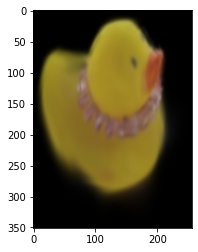

iteration 10, Loss = 0.5687410235404968
iteration 20, Loss = 0.5516006350517273
iteration 30, Loss = 0.557658314704895
iteration 40, Loss = 0.5550462603569031
iteration 50, Loss = 0.5398865342140198


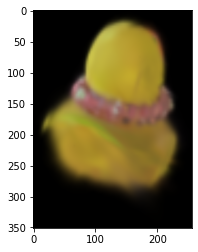

iteration 60, Loss = 0.547147810459137
iteration 70, Loss = 0.5496288537979126
iteration 80, Loss = 0.5370703339576721
iteration 90, Loss = 0.5342282652854919
iteration 100, Loss = 0.5361036062240601


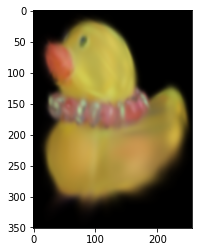

iteration 110, Loss = 0.5304514765739441
iteration 120, Loss = 0.5306434035301208
iteration 130, Loss = 0.5258885622024536
iteration 140, Loss = 0.5251364707946777
iteration 150, Loss = 0.5244724154472351


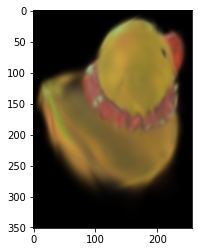

iteration 160, Loss = 0.5268917083740234
iteration 170, Loss = 0.5214613676071167
iteration 180, Loss = 0.5199935436248779
iteration 190, Loss = 0.5350325107574463
iteration 200, Loss = 0.5187634825706482


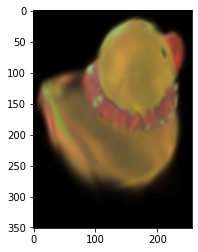

iteration 210, Loss = 0.5177039504051208
iteration 220, Loss = 0.5134891867637634
iteration 230, Loss = 0.5203065276145935
iteration 240, Loss = 0.5135061144828796
iteration 250, Loss = 0.5126020908355713


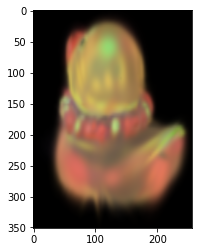

iteration 260, Loss = 0.5097827315330505
iteration 270, Loss = 0.532667338848114
iteration 280, Loss = 0.5100629329681396
iteration 290, Loss = 0.5149981379508972
iteration 300, Loss = 0.5134260058403015


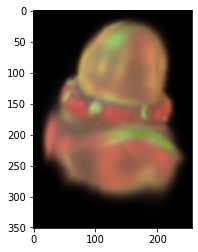

iteration 310, Loss = 0.5059964060783386
iteration 320, Loss = 0.5127350091934204
iteration 330, Loss = 0.512121856212616
iteration 340, Loss = 0.5100058317184448
iteration 350, Loss = 0.5081706643104553


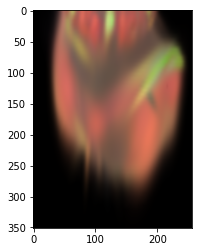

iteration 360, Loss = 0.5051841139793396
iteration 370, Loss = 0.5048574209213257
iteration 380, Loss = 0.5285371541976929
iteration 390, Loss = 0.5070539116859436
iteration 400, Loss = 0.49807533621788025


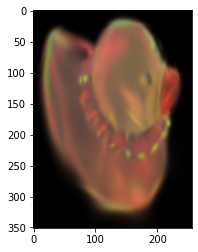

iteration 410, Loss = 0.5090497136116028
iteration 420, Loss = 0.5118054151535034
iteration 430, Loss = 0.5054498314857483
iteration 440, Loss = 0.5113834738731384
iteration 450, Loss = 0.5106474161148071


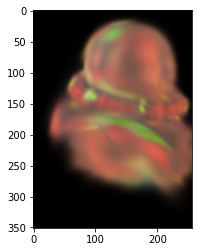

iteration 460, Loss = 0.5070272088050842
iteration 470, Loss = 0.5008331537246704
iteration 480, Loss = 0.5027597546577454
iteration 490, Loss = 0.5076805949211121
iteration 500, Loss = 0.501477837562561


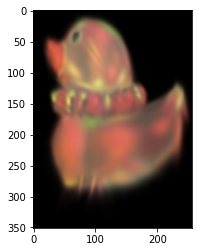

iteration 510, Loss = 0.5001474022865295
iteration 520, Loss = 0.49921324849128723
iteration 530, Loss = 0.49960699677467346
iteration 540, Loss = 0.49639585614204407
iteration 550, Loss = 0.4970550537109375


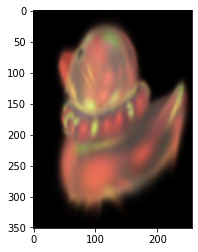

iteration 560, Loss = 0.4990033507347107
iteration 570, Loss = 0.5029667615890503
iteration 580, Loss = 0.5049430727958679
iteration 590, Loss = 0.49763402342796326
iteration 600, Loss = 0.5019703507423401


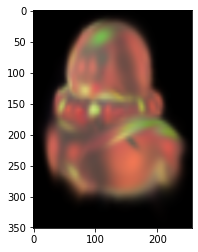

iteration 610, Loss = 0.5081936120986938
iteration 620, Loss = 0.4996309280395508
iteration 630, Loss = 0.4952619671821594
iteration 640, Loss = 0.501695990562439
iteration 650, Loss = 0.5237174034118652


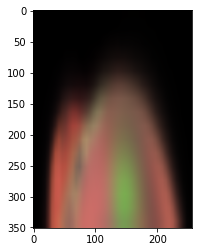

iteration 660, Loss = 0.501686692237854
iteration 670, Loss = 0.4989306628704071
iteration 680, Loss = 0.49866458773612976
iteration 690, Loss = 0.5113546252250671
iteration 700, Loss = 0.5110006332397461


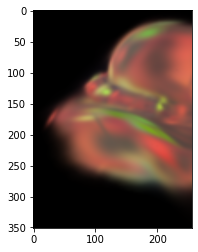

iteration 710, Loss = 0.5030999183654785
iteration 720, Loss = 0.4970129728317261
iteration 730, Loss = 0.49579232931137085
iteration 740, Loss = 0.5006750226020813
iteration 750, Loss = 0.5014805197715759


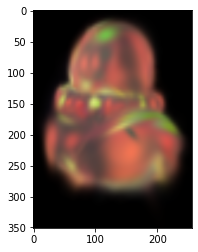

iteration 760, Loss = 0.5040411353111267
iteration 770, Loss = 0.49542438983917236
iteration 780, Loss = 0.4966135025024414
iteration 790, Loss = 0.4910431206226349
iteration 800, Loss = 0.4973558485507965


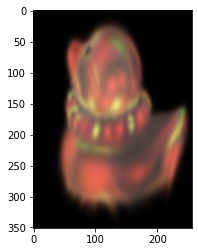

iteration 810, Loss = 0.4955141246318817
iteration 820, Loss = 0.4948151111602783
iteration 830, Loss = 0.494480162858963
iteration 840, Loss = 0.5019436478614807
iteration 850, Loss = 0.4971499741077423


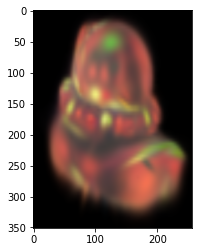

iteration 860, Loss = 0.4953586161136627
iteration 870, Loss = 0.4952986240386963
iteration 880, Loss = 0.496071994304657
iteration 890, Loss = 0.4976078271865845
iteration 900, Loss = 0.4931865930557251


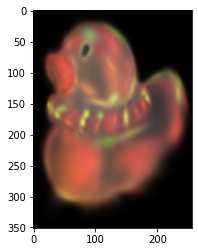

iteration 910, Loss = 0.48780471086502075
iteration 920, Loss = 0.49900388717651367
iteration 930, Loss = 0.4969272017478943
iteration 940, Loss = 0.492984801530838
iteration 950, Loss = 0.5014991164207458


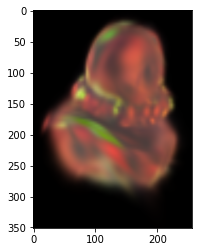

iteration 960, Loss = 0.503330647945404
iteration 970, Loss = 0.5219284296035767
iteration 980, Loss = 0.4972071945667267
iteration 990, Loss = 0.4940704107284546
iteration 1000, Loss = 0.5213678479194641


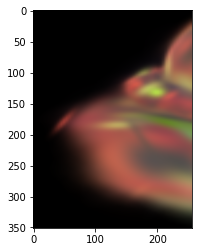

iteration 1010, Loss = 0.500407338142395
iteration 1020, Loss = 0.49515125155448914
iteration 1030, Loss = 0.5020067691802979
iteration 1040, Loss = 0.5026229023933411
iteration 1050, Loss = 0.49571022391319275


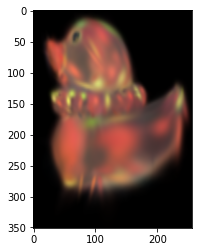

iteration 1060, Loss = 0.5010412931442261
iteration 1070, Loss = 0.4979408383369446
iteration 1080, Loss = 0.4955064058303833
iteration 1090, Loss = 0.48544058203697205
iteration 1100, Loss = 0.4921368658542633


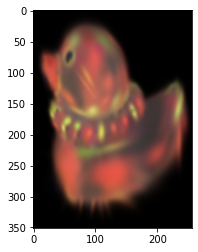

iteration 1110, Loss = 0.5181267857551575
iteration 1120, Loss = 0.49445223808288574
iteration 1130, Loss = 0.4917803406715393
iteration 1140, Loss = 0.48944684863090515
iteration 1150, Loss = 0.5082085132598877


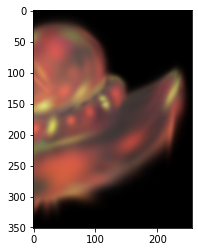

iteration 1160, Loss = 0.49030500650405884
iteration 1170, Loss = 0.4999575614929199
iteration 1180, Loss = 0.495475709438324
iteration 1190, Loss = 0.4926953911781311
iteration 1200, Loss = 0.4930607080459595


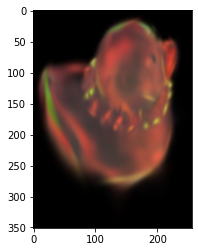

iteration 1210, Loss = 0.48862195014953613
iteration 1220, Loss = 0.5023100972175598
iteration 1230, Loss = 0.491546094417572
iteration 1240, Loss = 0.5004540681838989
iteration 1250, Loss = 0.49038177728652954


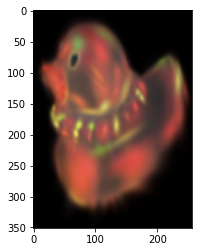

iteration 1260, Loss = 0.48419180512428284
iteration 1270, Loss = 0.5048152208328247
iteration 1280, Loss = 0.49200737476348877
iteration 1290, Loss = 0.4938115179538727
iteration 1300, Loss = 0.4935312271118164


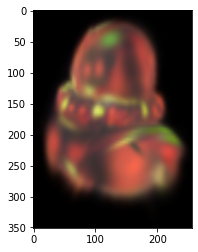

iteration 1310, Loss = 0.49137264490127563
iteration 1320, Loss = 0.4951688349246979
iteration 1330, Loss = 0.5025355219841003
iteration 1340, Loss = 0.4909275472164154
iteration 1350, Loss = 0.49403250217437744


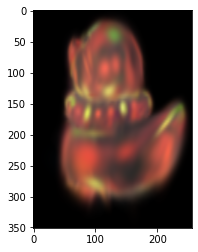

iteration 1360, Loss = 0.49738723039627075
iteration 1370, Loss = 0.4913558065891266
iteration 1380, Loss = 0.49429285526275635
iteration 1390, Loss = 0.49209463596343994
iteration 1400, Loss = 0.49429091811180115


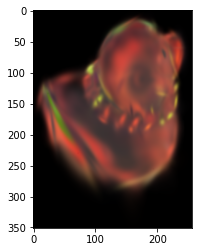

iteration 1410, Loss = 0.517246663570404
iteration 1420, Loss = 0.49250712990760803
iteration 1430, Loss = 0.49299103021621704
iteration 1440, Loss = 0.4925377070903778
iteration 1450, Loss = 0.4913955330848694


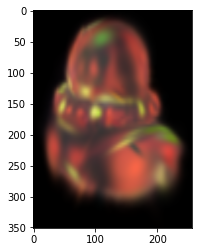

iteration 1460, Loss = 0.4958002269268036
iteration 1470, Loss = 0.4914238452911377
iteration 1480, Loss = 0.4954158365726471
iteration 1490, Loss = 0.4916401505470276
iteration 1500, Loss = 0.4905879497528076


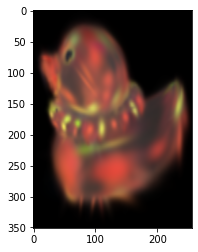

iteration 1510, Loss = 0.4913545846939087
iteration 1520, Loss = 0.49417632818222046
iteration 1530, Loss = 0.5028021335601807
iteration 1540, Loss = 0.4925025403499603
iteration 1550, Loss = 0.49130871891975403


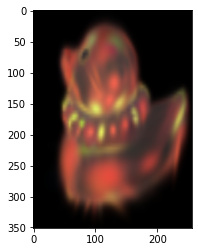

iteration 1560, Loss = 0.4910532236099243
iteration 1570, Loss = 0.4923505187034607
iteration 1580, Loss = 0.4919886887073517
iteration 1590, Loss = 0.490770548582077
iteration 1600, Loss = 0.4905940890312195


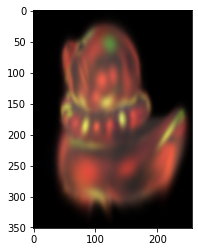

iteration 1610, Loss = 0.4970766603946686
iteration 1620, Loss = 0.4822638928890228
iteration 1630, Loss = 0.49009090662002563
iteration 1640, Loss = 0.4927233159542084
iteration 1650, Loss = 0.5018355250358582


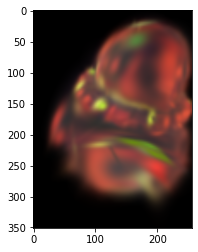

iteration 1660, Loss = 0.4905286729335785
iteration 1670, Loss = 0.48976072669029236
iteration 1680, Loss = 0.48920735716819763
iteration 1690, Loss = 0.48785653710365295
iteration 1700, Loss = 0.49279433488845825


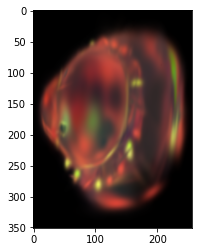

iteration 1710, Loss = 0.49107372760772705
iteration 1720, Loss = 0.49322745203971863
iteration 1730, Loss = 0.4930613338947296
iteration 1740, Loss = 0.5192900896072388
iteration 1750, Loss = 0.49218153953552246


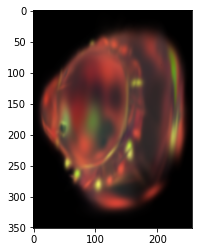

iteration 1760, Loss = 0.48878416419029236
iteration 1770, Loss = 0.49069446325302124
iteration 1780, Loss = 0.4916437566280365
iteration 1790, Loss = 0.5022583603858948
iteration 1800, Loss = 0.4996145963668823


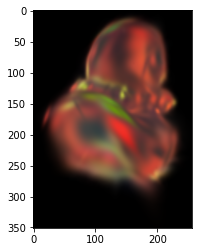

iteration 1810, Loss = 0.49257132411003113
iteration 1820, Loss = 0.49008554220199585
iteration 1830, Loss = 0.4940339922904968
iteration 1840, Loss = 0.4877550005912781
iteration 1850, Loss = 0.4938369691371918


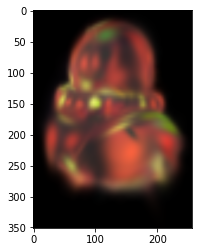

iteration 1860, Loss = 0.4892284870147705
iteration 1870, Loss = 0.48709461092948914
iteration 1880, Loss = 0.490393728017807
iteration 1890, Loss = 0.49240103363990784
iteration 1900, Loss = 0.48840850591659546


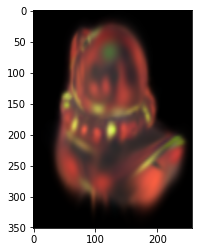

iteration 1910, Loss = 0.4917207360267639
iteration 1920, Loss = 0.49082955718040466
iteration 1930, Loss = 0.4974214732646942
iteration 1940, Loss = 0.48814716935157776
iteration 1950, Loss = 0.5160223245620728


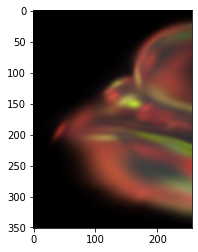

iteration 1960, Loss = 0.49590662121772766
iteration 1970, Loss = 0.4907992482185364
iteration 1980, Loss = 0.4904651939868927
iteration 1990, Loss = 0.5155408978462219


In [12]:
from torch import optim
import random
from torchvision.ops.boxes import masks_to_boxes
from torchvision.transforms.v2 import functional as Fv2

features_dc_opt = model.gauss_params["features_dc"][final_mask.detach()].cuda().detach()
features_dc_opt.requires_grad_(True)

means_opt = means.detach()
quats_opt = quats.detach()
scales_opt = scales.detach()
opacities_opt = opacities.detach()
# colors.requires_grad_(False)
optimizer = optim.AdamW([features_dc_opt], lr=0.01)

H = cameras.image_height[0].item()
W = cameras.image_width[0].item()


# Convert to torch
style_image = Fv2.pil_to_tensor(image).unsqueeze(0).cuda()
style_image = Fv2.to_dtype(style_image, torch.float32, scale=True)
style_image = Fv2.resize(style_image, 256)
nnfm_loss_fn = NNFMLoss("cuda")

# style_image = style_image.transpose(2, 3)
for i in range(2000):
    idx = random.choice(obj_cameras)
    viewmats = get_viewmat(cameras[idx : idx + 1].camera_to_worlds).cuda()
    Ks = cameras[0:1].get_intrinsics_matrices().cuda()
    # gt_img = image_dataset.get_image_float32(idx)
    optimizer.zero_grad(set_to_none=True)
    colors, alpha, meta = rasterization(
        means_opt,
        quats_opt,
        torch.exp(scales_opt),
        torch.sigmoid(opacities_opt).squeeze(-1),
        torch.sigmoid(features_dc_opt).squeeze(-1),
        viewmats,
        Ks,
        W,
        H,
        sh_degree=None,
        packed=False,
    )
    colors = colors.permute(0, 3, 1, 2)

    ###
    new_obj_mask = (colors > 0).any(dim=1)
    crop_box = masks_to_boxes(new_obj_mask)[0].to(int)
    new_rgb = colors[:, :, crop_box[1] : crop_box[3], crop_box[0] : crop_box[2]]
    new_rgb = Fv2.resize(new_rgb, style_image.shape[-2:])
    ###

    lossdict = nnfm_loss_fn(
        outputs=new_rgb,
        styles=style_image,
        loss_names=["nnfm_loss"],
    )
    loss = lossdict["nnfm_loss"]
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"iteration {i}, Loss =", loss.item())
        if i % 50 == 0:
            plt.imshow(new_rgb[0].cpu().detach().permute(1, 2, 0).numpy())
            plt.show()

## Test Style transfer in full scene

Change `viewmat` variable to render the styled image from different views.

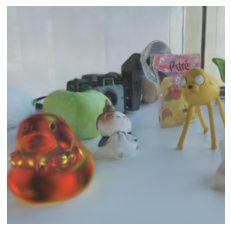

In [13]:
means = model.means.cuda()
quats = model.quats.cuda()
scales = model.scales.cuda()
features_dc = model.gauss_params["features_dc"].cuda().detach()
features_dc[final_mask] = features_dc_opt.detach()
opacities = model.opacities.cuda()

viewmats = get_viewmat(cameras[0:1].camera_to_worlds).cuda()
Ks = cameras[0:1].get_intrinsics_matrices().cuda()

colors, alpha, meta = rasterization(
    means,
    quats,
    torch.exp(scales),
    torch.sigmoid(opacities).squeeze(-1),
    torch.sigmoid(features_dc).squeeze(1),
    viewmats,
    Ks,
    512,
    512,
    sh_degree=None,
    packed=False,
)

plt.imshow(colors.cpu().detach().numpy().squeeze(0))
plt.axis("off")
plt.savefig("render1.png")  # plt.show

## Saving the styled Gaussians 

Not compatible yet with Nerfstudio. Try viewing it in Viser with simple_viewer.py.

In [14]:
save_dict = {
    "means": means.data,
    "quats": quats.data,
    "scales": scales.data,
    "opacities": opacities.data,
    "features_dc": features_dc.data,
}
torch.save(save_dict, "styled_figurines.pt")

In [15]:
# test_dict = torch.load("styled_figurines.pt")
# test_dict["means"]